In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn

5.973262521249683

## Initialize model at full charge to 4.1V

In [3]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-15,
    "SEI resistivity [Ohm.m]": 0,
})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [4]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 2.5
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.904538880886973
0.26790222708570915


## One cycle

In [5]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

In [6]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.6147638074320043, step=0.03614763807432004…

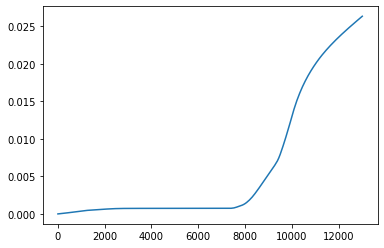

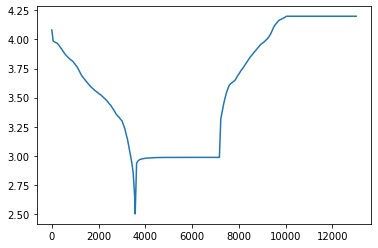

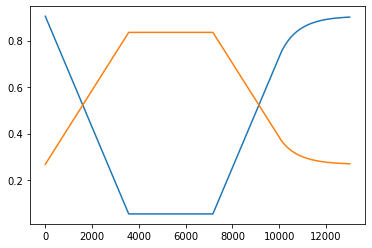

In [7]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [8]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## 10 cycles

In [9]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 200)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol_100 = sim_100.solve()

2021-03-03 10:24:29,157 - [NOTICE] simulation.solve(693): Cycle 1/200 (23.353 ms elapsed) --------------------
2021-03-03 10:24:29,158 - [NOTICE] simulation.solve(723): Cycle 1/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:24:29,356 - [NOTICE] simulation.solve(723): Cycle 1/200, step 2/4: Rest for 1 hour
2021-03-03 10:24:29,520 - [NOTICE] simulation.solve(723): Cycle 1/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:24:29,692 - [NOTICE] simulation.solve(723): Cycle 1/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:24:30,074 - [NOTICE] simulation.solve(693): Cycle 2/200 (940.258 ms elapsed) --------------------
2021-03-03 10:24:30,075 - [NOTICE] simulation.solve(723): Cycle 2/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:24:30,257 - [NOTICE] simulation.solve(723): Cycle 2/200, step 2/4: Rest for 1 hour
2021-03-03 10:24:30,404 - [NOTICE] simulation.solve(723): Cycle 2/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:24:30,557 - [NOTICE] simulation.solve(

2021-03-03 10:24:41,296 - [NOTICE] simulation.solve(723): Cycle 16/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:24:41,449 - [NOTICE] simulation.solve(723): Cycle 16/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:24:41,700 - [NOTICE] simulation.solve(693): Cycle 17/200 (12.566 s elapsed) --------------------
2021-03-03 10:24:41,701 - [NOTICE] simulation.solve(723): Cycle 17/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:24:41,866 - [NOTICE] simulation.solve(723): Cycle 17/200, step 2/4: Rest for 1 hour
2021-03-03 10:24:42,024 - [NOTICE] simulation.solve(723): Cycle 17/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:24:42,181 - [NOTICE] simulation.solve(723): Cycle 17/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:24:42,440 - [NOTICE] simulation.solve(693): Cycle 18/200 (13.306 s elapsed) --------------------
2021-03-03 10:24:42,441 - [NOTICE] simulation.solve(723): Cycle 18/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:24:42,629 - [NOTICE] sim

2021-03-03 10:24:53,734 - [NOTICE] simulation.solve(723): Cycle 32/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:24:53,910 - [NOTICE] simulation.solve(723): Cycle 32/200, step 2/4: Rest for 1 hour
2021-03-03 10:24:54,062 - [NOTICE] simulation.solve(723): Cycle 32/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:24:54,209 - [NOTICE] simulation.solve(723): Cycle 32/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:24:54,453 - [NOTICE] simulation.solve(693): Cycle 33/200 (25.319 s elapsed) --------------------
2021-03-03 10:24:54,454 - [NOTICE] simulation.solve(723): Cycle 33/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:24:54,649 - [NOTICE] simulation.solve(723): Cycle 33/200, step 2/4: Rest for 1 hour
2021-03-03 10:24:54,825 - [NOTICE] simulation.solve(723): Cycle 33/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:24:54,977 - [NOTICE] simulation.solve(723): Cycle 33/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:24:55,235 - [NOTICE] simulation.solve

2021-03-03 10:25:05,933 - [NOTICE] simulation.solve(723): Cycle 47/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:06,218 - [NOTICE] simulation.solve(693): Cycle 48/200 (37.084 s elapsed) --------------------
2021-03-03 10:25:06,219 - [NOTICE] simulation.solve(723): Cycle 48/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:06,428 - [NOTICE] simulation.solve(723): Cycle 48/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:06,661 - [NOTICE] simulation.solve(723): Cycle 48/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:06,874 - [NOTICE] simulation.solve(723): Cycle 48/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:07,184 - [NOTICE] simulation.solve(693): Cycle 49/200 (38.050 s elapsed) --------------------
2021-03-03 10:25:07,184 - [NOTICE] simulation.solve(723): Cycle 49/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:07,370 - [NOTICE] simulation.solve(723): Cycle 49/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:07,533 - [NOTICE] simulation.

2021-03-03 10:25:18,220 - [NOTICE] simulation.solve(723): Cycle 63/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:18,385 - [NOTICE] simulation.solve(723): Cycle 63/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:18,536 - [NOTICE] simulation.solve(723): Cycle 63/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:18,837 - [NOTICE] simulation.solve(693): Cycle 64/200 (49.703 s elapsed) --------------------
2021-03-03 10:25:18,838 - [NOTICE] simulation.solve(723): Cycle 64/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:19,048 - [NOTICE] simulation.solve(723): Cycle 64/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:19,204 - [NOTICE] simulation.solve(723): Cycle 64/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:19,350 - [NOTICE] simulation.solve(723): Cycle 64/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:19,622 - [NOTICE] simulation.solve(693): Cycle 65/200 (50.487 s elapsed) --------------------
2021-03-03 10:25:19,622 - [NOTICE] simulation.sol

2021-03-03 10:25:30,968 - [NOTICE] simulation.solve(693): Cycle 79/200 (1 minute, 2 seconds elapsed) --------------------
2021-03-03 10:25:30,969 - [NOTICE] simulation.solve(723): Cycle 79/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:31,171 - [NOTICE] simulation.solve(723): Cycle 79/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:31,360 - [NOTICE] simulation.solve(723): Cycle 79/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:31,522 - [NOTICE] simulation.solve(723): Cycle 79/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:31,813 - [NOTICE] simulation.solve(693): Cycle 80/200 (1 minute, 3 seconds elapsed) --------------------
2021-03-03 10:25:31,813 - [NOTICE] simulation.solve(723): Cycle 80/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:31,993 - [NOTICE] simulation.solve(723): Cycle 80/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:32,155 - [NOTICE] simulation.solve(723): Cycle 80/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:32,289 

2021-03-03 10:25:43,678 - [NOTICE] simulation.solve(723): Cycle 94/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:43,880 - [NOTICE] simulation.solve(723): Cycle 94/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:44,080 - [NOTICE] simulation.solve(723): Cycle 94/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:44,228 - [NOTICE] simulation.solve(723): Cycle 94/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:44,545 - [NOTICE] simulation.solve(693): Cycle 95/200 (1 minute, 15 seconds elapsed) --------------------
2021-03-03 10:25:44,546 - [NOTICE] simulation.solve(723): Cycle 95/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:44,745 - [NOTICE] simulation.solve(723): Cycle 95/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:44,940 - [NOTICE] simulation.solve(723): Cycle 95/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:45,089 - [NOTICE] simulation.solve(723): Cycle 95/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:45,386 - [NOTICE] simu

2021-03-03 10:25:56,824 - [NOTICE] simulation.solve(723): Cycle 109/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:56,984 - [NOTICE] simulation.solve(723): Cycle 109/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:57,135 - [NOTICE] simulation.solve(723): Cycle 109/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:57,439 - [NOTICE] simulation.solve(693): Cycle 110/200 (1 minute, 28 seconds elapsed) --------------------
2021-03-03 10:25:57,440 - [NOTICE] simulation.solve(723): Cycle 110/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:25:57,612 - [NOTICE] simulation.solve(723): Cycle 110/200, step 2/4: Rest for 1 hour
2021-03-03 10:25:57,825 - [NOTICE] simulation.solve(723): Cycle 110/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:25:57,999 - [NOTICE] simulation.solve(723): Cycle 110/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:25:58,286 - [NOTICE] simulation.solve(693): Cycle 111/200 (1 minute, 29 seconds elapsed) --------------------
2021-03-03 10:25

2021-03-03 10:26:08,680 - [NOTICE] simulation.solve(723): Cycle 124/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:08,849 - [NOTICE] simulation.solve(723): Cycle 124/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:08,989 - [NOTICE] simulation.solve(723): Cycle 124/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:09,248 - [NOTICE] simulation.solve(693): Cycle 125/200 (1 minute, 40 seconds elapsed) --------------------
2021-03-03 10:26:09,248 - [NOTICE] simulation.solve(723): Cycle 125/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:26:09,436 - [NOTICE] simulation.solve(723): Cycle 125/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:09,629 - [NOTICE] simulation.solve(723): Cycle 125/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:09,788 - [NOTICE] simulation.solve(723): Cycle 125/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:10,086 - [NOTICE] simulation.solve(693): Cycle 126/200 (1 minute, 41 seconds elapsed) --------------------
2021-03-03 10:26

2021-03-03 10:26:20,355 - [NOTICE] simulation.solve(723): Cycle 139/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:20,516 - [NOTICE] simulation.solve(723): Cycle 139/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:20,657 - [NOTICE] simulation.solve(723): Cycle 139/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:20,922 - [NOTICE] simulation.solve(693): Cycle 140/200 (1 minute, 52 seconds elapsed) --------------------
2021-03-03 10:26:20,922 - [NOTICE] simulation.solve(723): Cycle 140/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:26:21,088 - [NOTICE] simulation.solve(723): Cycle 140/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:21,252 - [NOTICE] simulation.solve(723): Cycle 140/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:21,391 - [NOTICE] simulation.solve(723): Cycle 140/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:21,695 - [NOTICE] simulation.solve(693): Cycle 141/200 (1 minute, 53 seconds elapsed) --------------------
2021-03-03 10:26

2021-03-03 10:26:32,160 - [NOTICE] simulation.solve(723): Cycle 154/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:32,331 - [NOTICE] simulation.solve(723): Cycle 154/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:32,485 - [NOTICE] simulation.solve(723): Cycle 154/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:32,776 - [NOTICE] simulation.solve(693): Cycle 155/200 (2 minutes, 4 seconds elapsed) --------------------
2021-03-03 10:26:32,777 - [NOTICE] simulation.solve(723): Cycle 155/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:26:32,960 - [NOTICE] simulation.solve(723): Cycle 155/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:33,128 - [NOTICE] simulation.solve(723): Cycle 155/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:33,269 - [NOTICE] simulation.solve(723): Cycle 155/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:33,532 - [NOTICE] simulation.solve(693): Cycle 156/200 (2 minutes, 4 seconds elapsed) --------------------
2021-03-03 10:26

2021-03-03 10:26:43,644 - [NOTICE] simulation.solve(723): Cycle 169/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:43,834 - [NOTICE] simulation.solve(723): Cycle 169/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:43,978 - [NOTICE] simulation.solve(723): Cycle 169/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:44,247 - [NOTICE] simulation.solve(693): Cycle 170/200 (2 minutes, 15 seconds elapsed) --------------------
2021-03-03 10:26:44,247 - [NOTICE] simulation.solve(723): Cycle 170/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:26:44,414 - [NOTICE] simulation.solve(723): Cycle 170/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:44,896 - [NOTICE] simulation.solve(723): Cycle 170/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:45,067 - [NOTICE] simulation.solve(723): Cycle 170/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:45,334 - [NOTICE] simulation.solve(693): Cycle 171/200 (2 minutes, 16 seconds elapsed) --------------------
2021-03-03 10:

2021-03-03 10:26:56,503 - [NOTICE] simulation.solve(723): Cycle 184/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:56,685 - [NOTICE] simulation.solve(723): Cycle 184/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:56,829 - [NOTICE] simulation.solve(723): Cycle 184/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:57,080 - [NOTICE] simulation.solve(693): Cycle 185/200 (2 minutes, 28 seconds elapsed) --------------------
2021-03-03 10:26:57,080 - [NOTICE] simulation.solve(723): Cycle 185/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:26:57,283 - [NOTICE] simulation.solve(723): Cycle 185/200, step 2/4: Rest for 1 hour
2021-03-03 10:26:57,480 - [NOTICE] simulation.solve(723): Cycle 185/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:26:57,661 - [NOTICE] simulation.solve(723): Cycle 185/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:26:57,969 - [NOTICE] simulation.solve(693): Cycle 186/200 (2 minutes, 29 seconds elapsed) --------------------
2021-03-03 10:

2021-03-03 10:27:09,023 - [NOTICE] simulation.solve(723): Cycle 199/200, step 2/4: Rest for 1 hour
2021-03-03 10:27:09,216 - [NOTICE] simulation.solve(723): Cycle 199/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:09,378 - [NOTICE] simulation.solve(723): Cycle 199/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:09,674 - [NOTICE] simulation.solve(693): Cycle 200/200 (2 minutes, 41 seconds elapsed) --------------------
2021-03-03 10:27:09,675 - [NOTICE] simulation.solve(723): Cycle 200/200, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:09,862 - [NOTICE] simulation.solve(723): Cycle 200/200, step 2/4: Rest for 1 hour
2021-03-03 10:27:10,047 - [NOTICE] simulation.solve(723): Cycle 200/200, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:10,216 - [NOTICE] simulation.solve(723): Cycle 200/200, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:10,497 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 2 minutes, 41 seconds


In [11]:
spm_sol_400 = sim_100.solve(starting_solution=spm_sol_100)

2021-03-03 10:27:15,613 - [NOTICE] simulation.solve(693): Cycle 201/400 (40.286 ms elapsed) --------------------
2021-03-03 10:27:15,614 - [NOTICE] simulation.solve(723): Cycle 201/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:15,805 - [NOTICE] simulation.solve(723): Cycle 201/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:15,990 - [NOTICE] simulation.solve(723): Cycle 201/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:16,144 - [NOTICE] simulation.solve(723): Cycle 201/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:16,531 - [NOTICE] simulation.solve(693): Cycle 202/400 (957.932 ms elapsed) --------------------
2021-03-03 10:27:16,531 - [NOTICE] simulation.solve(723): Cycle 202/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:16,711 - [NOTICE] simulation.solve(723): Cycle 202/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:16,886 - [NOTICE] simulation.solve(723): Cycle 202/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:17,046 - [NOTICE]

2021-03-03 10:27:28,341 - [NOTICE] simulation.solve(723): Cycle 216/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:28,512 - [NOTICE] simulation.solve(723): Cycle 216/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:28,669 - [NOTICE] simulation.solve(723): Cycle 216/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:28,960 - [NOTICE] simulation.solve(693): Cycle 217/400 (13.387 s elapsed) --------------------
2021-03-03 10:27:28,961 - [NOTICE] simulation.solve(723): Cycle 217/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:29,136 - [NOTICE] simulation.solve(723): Cycle 217/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:29,326 - [NOTICE] simulation.solve(723): Cycle 217/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:29,493 - [NOTICE] simulation.solve(723): Cycle 217/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:29,791 - [NOTICE] simulation.solve(693): Cycle 218/400 (14.218 s elapsed) --------------------
2021-03-03 10:27:29,792 - [NOTICE] simul

2021-03-03 10:27:41,629 - [NOTICE] simulation.solve(723): Cycle 231/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:41,913 - [NOTICE] simulation.solve(693): Cycle 232/400 (26.340 s elapsed) --------------------
2021-03-03 10:27:41,913 - [NOTICE] simulation.solve(723): Cycle 232/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:42,114 - [NOTICE] simulation.solve(723): Cycle 232/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:42,296 - [NOTICE] simulation.solve(723): Cycle 232/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:42,451 - [NOTICE] simulation.solve(723): Cycle 232/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:42,763 - [NOTICE] simulation.solve(693): Cycle 233/400 (27.191 s elapsed) --------------------
2021-03-03 10:27:42,764 - [NOTICE] simulation.solve(723): Cycle 233/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:42,953 - [NOTICE] simulation.solve(723): Cycle 233/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:43,145 - [NOTICE] si

2021-03-03 10:27:54,936 - [NOTICE] simulation.solve(723): Cycle 247/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:55,171 - [NOTICE] simulation.solve(723): Cycle 247/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:55,426 - [NOTICE] simulation.solve(723): Cycle 247/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:55,617 - [NOTICE] simulation.solve(723): Cycle 247/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:55,933 - [NOTICE] simulation.solve(693): Cycle 248/400 (40.358 s elapsed) --------------------
2021-03-03 10:27:55,934 - [NOTICE] simulation.solve(723): Cycle 248/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:27:56,105 - [NOTICE] simulation.solve(723): Cycle 248/400, step 2/4: Rest for 1 hour
2021-03-03 10:27:56,329 - [NOTICE] simulation.solve(723): Cycle 248/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:27:56,499 - [NOTICE] simulation.solve(723): Cycle 248/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:27:56,801 - [NOTICE] simulat

2021-03-03 10:28:07,918 - [NOTICE] simulation.solve(723): Cycle 262/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:28:08,083 - [NOTICE] simulation.solve(723): Cycle 262/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:08,349 - [NOTICE] simulation.solve(693): Cycle 263/400 (52.770 s elapsed) --------------------
2021-03-03 10:28:08,356 - [NOTICE] simulation.solve(723): Cycle 263/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:08,527 - [NOTICE] simulation.solve(723): Cycle 263/400, step 2/4: Rest for 1 hour
2021-03-03 10:28:08,708 - [NOTICE] simulation.solve(723): Cycle 263/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:28:08,858 - [NOTICE] simulation.solve(723): Cycle 263/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:09,136 - [NOTICE] simulation.solve(693): Cycle 264/400 (53.557 s elapsed) --------------------
2021-03-03 10:28:09,136 - [NOTICE] simulation.solve(723): Cycle 264/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:09,333 - [NO

2021-03-03 10:28:20,473 - [NOTICE] simulation.solve(723): Cycle 277/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:20,755 - [NOTICE] simulation.solve(693): Cycle 278/400 (1 minute, 5 seconds elapsed) --------------------
2021-03-03 10:28:20,756 - [NOTICE] simulation.solve(723): Cycle 278/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:20,930 - [NOTICE] simulation.solve(723): Cycle 278/400, step 2/4: Rest for 1 hour
2021-03-03 10:28:21,118 - [NOTICE] simulation.solve(723): Cycle 278/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:28:21,283 - [NOTICE] simulation.solve(723): Cycle 278/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:21,610 - [NOTICE] simulation.solve(693): Cycle 279/400 (1 minute, 6 seconds elapsed) --------------------
2021-03-03 10:28:21,611 - [NOTICE] simulation.solve(723): Cycle 279/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:21,810 - [NOTICE] simulation.solve(723): Cycle 279/400, step 2/4: Rest for 1 hour
2021-03-03 10:2

2021-03-03 10:28:33,348 - [NOTICE] simulation.solve(723): Cycle 292/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:33,648 - [NOTICE] simulation.solve(693): Cycle 293/400 (1 minute, 18 seconds elapsed) --------------------
2021-03-03 10:28:33,649 - [NOTICE] simulation.solve(723): Cycle 293/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:33,831 - [NOTICE] simulation.solve(723): Cycle 293/400, step 2/4: Rest for 1 hour
2021-03-03 10:28:34,019 - [NOTICE] simulation.solve(723): Cycle 293/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:28:34,161 - [NOTICE] simulation.solve(723): Cycle 293/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:34,464 - [NOTICE] simulation.solve(693): Cycle 294/400 (1 minute, 19 seconds elapsed) --------------------
2021-03-03 10:28:34,464 - [NOTICE] simulation.solve(723): Cycle 294/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:34,642 - [NOTICE] simulation.solve(723): Cycle 294/400, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:28:47,609 - [NOTICE] simulation.solve(723): Cycle 307/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:47,922 - [NOTICE] simulation.solve(693): Cycle 308/400 (1 minute, 32 seconds elapsed) --------------------
2021-03-03 10:28:47,923 - [NOTICE] simulation.solve(723): Cycle 308/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:48,123 - [NOTICE] simulation.solve(723): Cycle 308/400, step 2/4: Rest for 1 hour
2021-03-03 10:28:48,324 - [NOTICE] simulation.solve(723): Cycle 308/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:28:48,499 - [NOTICE] simulation.solve(723): Cycle 308/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:28:48,825 - [NOTICE] simulation.solve(693): Cycle 309/400 (1 minute, 33 seconds elapsed) --------------------
2021-03-03 10:28:48,826 - [NOTICE] simulation.solve(723): Cycle 309/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:28:48,992 - [NOTICE] simulation.solve(723): Cycle 309/400, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:29:02,024 - [NOTICE] simulation.solve(723): Cycle 322/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:02,426 - [NOTICE] simulation.solve(693): Cycle 323/400 (1 minute, 47 seconds elapsed) --------------------
2021-03-03 10:29:02,427 - [NOTICE] simulation.solve(723): Cycle 323/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:02,661 - [NOTICE] simulation.solve(723): Cycle 323/400, step 2/4: Rest for 1 hour
2021-03-03 10:29:02,882 - [NOTICE] simulation.solve(723): Cycle 323/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:29:03,075 - [NOTICE] simulation.solve(723): Cycle 323/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:03,446 - [NOTICE] simulation.solve(693): Cycle 324/400 (1 minute, 48 seconds elapsed) --------------------
2021-03-03 10:29:03,446 - [NOTICE] simulation.solve(723): Cycle 324/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:03,680 - [NOTICE] simulation.solve(723): Cycle 324/400, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:29:16,686 - [NOTICE] simulation.solve(723): Cycle 337/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:16,997 - [NOTICE] simulation.solve(693): Cycle 338/400 (2 minutes, 1 second elapsed) --------------------
2021-03-03 10:29:16,998 - [NOTICE] simulation.solve(723): Cycle 338/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:17,202 - [NOTICE] simulation.solve(723): Cycle 338/400, step 2/4: Rest for 1 hour
2021-03-03 10:29:17,411 - [NOTICE] simulation.solve(723): Cycle 338/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:29:17,589 - [NOTICE] simulation.solve(723): Cycle 338/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:17,953 - [NOTICE] simulation.solve(693): Cycle 339/400 (2 minutes, 2 seconds elapsed) --------------------
2021-03-03 10:29:17,953 - [NOTICE] simulation.solve(723): Cycle 339/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:18,146 - [NOTICE] simulation.solve(723): Cycle 339/400, step 2/4: Rest for 1 hour
2021-03-03 10:

2021-03-03 10:29:30,110 - [NOTICE] simulation.solve(723): Cycle 352/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:30,396 - [NOTICE] simulation.solve(693): Cycle 353/400 (2 minutes, 15 seconds elapsed) --------------------
2021-03-03 10:29:30,397 - [NOTICE] simulation.solve(723): Cycle 353/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:30,577 - [NOTICE] simulation.solve(723): Cycle 353/400, step 2/4: Rest for 1 hour
2021-03-03 10:29:30,774 - [NOTICE] simulation.solve(723): Cycle 353/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:29:30,941 - [NOTICE] simulation.solve(723): Cycle 353/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:31,243 - [NOTICE] simulation.solve(693): Cycle 354/400 (2 minutes, 16 seconds elapsed) --------------------
2021-03-03 10:29:31,243 - [NOTICE] simulation.solve(723): Cycle 354/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:31,426 - [NOTICE] simulation.solve(723): Cycle 354/400, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:29:42,827 - [NOTICE] simulation.solve(723): Cycle 367/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:43,138 - [NOTICE] simulation.solve(693): Cycle 368/400 (2 minutes, 28 seconds elapsed) --------------------
2021-03-03 10:29:43,139 - [NOTICE] simulation.solve(723): Cycle 368/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:43,347 - [NOTICE] simulation.solve(723): Cycle 368/400, step 2/4: Rest for 1 hour
2021-03-03 10:29:43,536 - [NOTICE] simulation.solve(723): Cycle 368/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:29:43,693 - [NOTICE] simulation.solve(723): Cycle 368/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:43,978 - [NOTICE] simulation.solve(693): Cycle 369/400 (2 minutes, 28 seconds elapsed) --------------------
2021-03-03 10:29:43,979 - [NOTICE] simulation.solve(723): Cycle 369/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:44,158 - [NOTICE] simulation.solve(723): Cycle 369/400, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:29:56,568 - [NOTICE] simulation.solve(723): Cycle 382/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:56,910 - [NOTICE] simulation.solve(693): Cycle 383/400 (2 minutes, 41 seconds elapsed) --------------------
2021-03-03 10:29:56,911 - [NOTICE] simulation.solve(723): Cycle 383/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:57,103 - [NOTICE] simulation.solve(723): Cycle 383/400, step 2/4: Rest for 1 hour
2021-03-03 10:29:57,346 - [NOTICE] simulation.solve(723): Cycle 383/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:29:57,513 - [NOTICE] simulation.solve(723): Cycle 383/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:29:57,878 - [NOTICE] simulation.solve(693): Cycle 384/400 (2 minutes, 42 seconds elapsed) --------------------
2021-03-03 10:29:57,879 - [NOTICE] simulation.solve(723): Cycle 384/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:29:58,083 - [NOTICE] simulation.solve(723): Cycle 384/400, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:30:11,709 - [NOTICE] simulation.solve(723): Cycle 397/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:30:12,042 - [NOTICE] simulation.solve(693): Cycle 398/400 (2 minutes, 56 seconds elapsed) --------------------
2021-03-03 10:30:12,043 - [NOTICE] simulation.solve(723): Cycle 398/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:30:12,221 - [NOTICE] simulation.solve(723): Cycle 398/400, step 2/4: Rest for 1 hour
2021-03-03 10:30:12,425 - [NOTICE] simulation.solve(723): Cycle 398/400, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:30:12,595 - [NOTICE] simulation.solve(723): Cycle 398/400, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:30:12,943 - [NOTICE] simulation.solve(693): Cycle 399/400 (2 minutes, 57 seconds elapsed) --------------------
2021-03-03 10:30:12,944 - [NOTICE] simulation.solve(723): Cycle 399/400, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:30:13,133 - [NOTICE] simulation.solve(723): Cycle 399/400, step 2/4: Rest for 1 hour
2021-03-03 

In [13]:
spm_sol_600 = sim_100.solve(starting_solution=spm_sol_400)

2021-03-03 10:31:20,488 - [NOTICE] simulation.solve(693): Cycle 401/600 (47.763 ms elapsed) --------------------
2021-03-03 10:31:20,489 - [NOTICE] simulation.solve(723): Cycle 401/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:31:20,684 - [NOTICE] simulation.solve(723): Cycle 401/600, step 2/4: Rest for 1 hour
2021-03-03 10:31:20,906 - [NOTICE] simulation.solve(723): Cycle 401/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:31:21,097 - [NOTICE] simulation.solve(723): Cycle 401/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:31:21,550 - [NOTICE] simulation.solve(693): Cycle 402/600 (1.110 s elapsed) --------------------
2021-03-03 10:31:21,551 - [NOTICE] simulation.solve(723): Cycle 402/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:31:21,742 - [NOTICE] simulation.solve(723): Cycle 402/600, step 2/4: Rest for 1 hour
2021-03-03 10:31:21,969 - [NOTICE] simulation.solve(723): Cycle 402/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:31:22,144 - [NOTICE] si

2021-03-03 10:31:34,858 - [NOTICE] simulation.solve(723): Cycle 416/600, step 2/4: Rest for 1 hour
2021-03-03 10:31:35,052 - [NOTICE] simulation.solve(723): Cycle 416/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:31:35,202 - [NOTICE] simulation.solve(723): Cycle 416/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:31:35,489 - [NOTICE] simulation.solve(693): Cycle 417/600 (15.048 s elapsed) --------------------
2021-03-03 10:31:35,489 - [NOTICE] simulation.solve(723): Cycle 417/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:31:35,650 - [NOTICE] simulation.solve(723): Cycle 417/600, step 2/4: Rest for 1 hour
2021-03-03 10:31:35,852 - [NOTICE] simulation.solve(723): Cycle 417/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:31:36,012 - [NOTICE] simulation.solve(723): Cycle 417/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:31:36,303 - [NOTICE] simulation.solve(693): Cycle 418/600 (15.863 s elapsed) --------------------
2021-03-03 10:31:36,304 - [NOTICE] simul

2021-03-03 10:31:48,685 - [NOTICE] simulation.solve(723): Cycle 431/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:31:49,057 - [NOTICE] simulation.solve(693): Cycle 432/600 (28.617 s elapsed) --------------------
2021-03-03 10:31:49,058 - [NOTICE] simulation.solve(723): Cycle 432/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:31:49,244 - [NOTICE] simulation.solve(723): Cycle 432/600, step 2/4: Rest for 1 hour
2021-03-03 10:31:49,461 - [NOTICE] simulation.solve(723): Cycle 432/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:31:49,639 - [NOTICE] simulation.solve(723): Cycle 432/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:31:50,058 - [NOTICE] simulation.solve(693): Cycle 433/600 (29.618 s elapsed) --------------------
2021-03-03 10:31:50,059 - [NOTICE] simulation.solve(723): Cycle 433/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:31:50,280 - [NOTICE] simulation.solve(723): Cycle 433/600, step 2/4: Rest for 1 hour
2021-03-03 10:31:50,531 - [NOTICE] si

2021-03-03 10:32:03,340 - [NOTICE] simulation.solve(723): Cycle 447/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:03,552 - [NOTICE] simulation.solve(723): Cycle 447/600, step 2/4: Rest for 1 hour
2021-03-03 10:32:03,782 - [NOTICE] simulation.solve(723): Cycle 447/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:32:03,964 - [NOTICE] simulation.solve(723): Cycle 447/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:04,291 - [NOTICE] simulation.solve(693): Cycle 448/600 (43.850 s elapsed) --------------------
2021-03-03 10:32:04,292 - [NOTICE] simulation.solve(723): Cycle 448/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:04,490 - [NOTICE] simulation.solve(723): Cycle 448/600, step 2/4: Rest for 1 hour
2021-03-03 10:32:04,723 - [NOTICE] simulation.solve(723): Cycle 448/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:32:04,900 - [NOTICE] simulation.solve(723): Cycle 448/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:05,255 - [NOTICE] simulat

2021-03-03 10:32:17,862 - [NOTICE] simulation.solve(723): Cycle 462/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:32:18,068 - [NOTICE] simulation.solve(723): Cycle 462/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:18,409 - [NOTICE] simulation.solve(693): Cycle 463/600 (57.968 s elapsed) --------------------
2021-03-03 10:32:18,410 - [NOTICE] simulation.solve(723): Cycle 463/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:18,625 - [NOTICE] simulation.solve(723): Cycle 463/600, step 2/4: Rest for 1 hour
2021-03-03 10:32:18,862 - [NOTICE] simulation.solve(723): Cycle 463/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:32:19,044 - [NOTICE] simulation.solve(723): Cycle 463/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:19,384 - [NOTICE] simulation.solve(693): Cycle 464/600 (58.943 s elapsed) --------------------
2021-03-03 10:32:19,385 - [NOTICE] simulation.solve(723): Cycle 464/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:19,590 - [NO

2021-03-03 10:32:32,470 - [NOTICE] simulation.solve(723): Cycle 477/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:32,821 - [NOTICE] simulation.solve(693): Cycle 478/600 (1 minute, 12 seconds elapsed) --------------------
2021-03-03 10:32:32,822 - [NOTICE] simulation.solve(723): Cycle 478/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:33,016 - [NOTICE] simulation.solve(723): Cycle 478/600, step 2/4: Rest for 1 hour
2021-03-03 10:32:33,261 - [NOTICE] simulation.solve(723): Cycle 478/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:32:33,440 - [NOTICE] simulation.solve(723): Cycle 478/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:33,786 - [NOTICE] simulation.solve(693): Cycle 479/600 (1 minute, 13 seconds elapsed) --------------------
2021-03-03 10:32:33,786 - [NOTICE] simulation.solve(723): Cycle 479/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:33,985 - [NOTICE] simulation.solve(723): Cycle 479/600, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:32:46,646 - [NOTICE] simulation.solve(723): Cycle 492/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:46,959 - [NOTICE] simulation.solve(693): Cycle 493/600 (1 minute, 27 seconds elapsed) --------------------
2021-03-03 10:32:46,960 - [NOTICE] simulation.solve(723): Cycle 493/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:47,165 - [NOTICE] simulation.solve(723): Cycle 493/600, step 2/4: Rest for 1 hour
2021-03-03 10:32:47,408 - [NOTICE] simulation.solve(723): Cycle 493/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:32:47,582 - [NOTICE] simulation.solve(723): Cycle 493/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:32:47,938 - [NOTICE] simulation.solve(693): Cycle 494/600 (1 minute, 27 seconds elapsed) --------------------
2021-03-03 10:32:47,938 - [NOTICE] simulation.solve(723): Cycle 494/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:32:48,177 - [NOTICE] simulation.solve(723): Cycle 494/600, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:33:02,177 - [NOTICE] simulation.solve(723): Cycle 507/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:02,508 - [NOTICE] simulation.solve(693): Cycle 508/600 (1 minute, 42 seconds elapsed) --------------------
2021-03-03 10:33:02,508 - [NOTICE] simulation.solve(723): Cycle 508/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:02,719 - [NOTICE] simulation.solve(723): Cycle 508/600, step 2/4: Rest for 1 hour
2021-03-03 10:33:02,961 - [NOTICE] simulation.solve(723): Cycle 508/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:33:04,138 - [NOTICE] simulation.solve(723): Cycle 508/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:04,503 - [NOTICE] simulation.solve(693): Cycle 509/600 (1 minute, 44 seconds elapsed) --------------------
2021-03-03 10:33:04,503 - [NOTICE] simulation.solve(723): Cycle 509/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:04,717 - [NOTICE] simulation.solve(723): Cycle 509/600, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:33:18,118 - [NOTICE] simulation.solve(723): Cycle 522/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:18,459 - [NOTICE] simulation.solve(693): Cycle 523/600 (1 minute, 58 seconds elapsed) --------------------
2021-03-03 10:33:18,460 - [NOTICE] simulation.solve(723): Cycle 523/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:18,686 - [NOTICE] simulation.solve(723): Cycle 523/600, step 2/4: Rest for 1 hour
2021-03-03 10:33:18,933 - [NOTICE] simulation.solve(723): Cycle 523/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:33:19,130 - [NOTICE] simulation.solve(723): Cycle 523/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:19,483 - [NOTICE] simulation.solve(693): Cycle 524/600 (1 minute, 59 seconds elapsed) --------------------
2021-03-03 10:33:19,484 - [NOTICE] simulation.solve(723): Cycle 524/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:19,705 - [NOTICE] simulation.solve(723): Cycle 524/600, step 2/4: Rest for 1 hour
2021-03-03 10

2021-03-03 10:33:32,981 - [NOTICE] simulation.solve(723): Cycle 537/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:33,314 - [NOTICE] simulation.solve(693): Cycle 538/600 (2 minutes, 13 seconds elapsed) --------------------
2021-03-03 10:33:33,315 - [NOTICE] simulation.solve(723): Cycle 538/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:33,526 - [NOTICE] simulation.solve(723): Cycle 538/600, step 2/4: Rest for 1 hour
2021-03-03 10:33:33,758 - [NOTICE] simulation.solve(723): Cycle 538/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:33:33,957 - [NOTICE] simulation.solve(723): Cycle 538/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:34,305 - [NOTICE] simulation.solve(693): Cycle 539/600 (2 minutes, 14 seconds elapsed) --------------------
2021-03-03 10:33:34,305 - [NOTICE] simulation.solve(723): Cycle 539/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:34,502 - [NOTICE] simulation.solve(723): Cycle 539/600, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:33:47,840 - [NOTICE] simulation.solve(723): Cycle 552/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:48,186 - [NOTICE] simulation.solve(693): Cycle 553/600 (2 minutes, 28 seconds elapsed) --------------------
2021-03-03 10:33:48,187 - [NOTICE] simulation.solve(723): Cycle 553/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:48,403 - [NOTICE] simulation.solve(723): Cycle 553/600, step 2/4: Rest for 1 hour
2021-03-03 10:33:48,658 - [NOTICE] simulation.solve(723): Cycle 553/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:33:48,855 - [NOTICE] simulation.solve(723): Cycle 553/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:33:49,225 - [NOTICE] simulation.solve(693): Cycle 554/600 (2 minutes, 29 seconds elapsed) --------------------
2021-03-03 10:33:49,226 - [NOTICE] simulation.solve(723): Cycle 554/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:33:49,433 - [NOTICE] simulation.solve(723): Cycle 554/600, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:34:02,900 - [NOTICE] simulation.solve(723): Cycle 567/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:03,240 - [NOTICE] simulation.solve(693): Cycle 568/600 (2 minutes, 43 seconds elapsed) --------------------
2021-03-03 10:34:03,241 - [NOTICE] simulation.solve(723): Cycle 568/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:03,455 - [NOTICE] simulation.solve(723): Cycle 568/600, step 2/4: Rest for 1 hour
2021-03-03 10:34:03,695 - [NOTICE] simulation.solve(723): Cycle 568/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:03,899 - [NOTICE] simulation.solve(723): Cycle 568/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:04,275 - [NOTICE] simulation.solve(693): Cycle 569/600 (2 minutes, 44 seconds elapsed) --------------------
2021-03-03 10:34:04,275 - [NOTICE] simulation.solve(723): Cycle 569/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:04,473 - [NOTICE] simulation.solve(723): Cycle 569/600, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:34:18,069 - [NOTICE] simulation.solve(723): Cycle 582/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:18,424 - [NOTICE] simulation.solve(693): Cycle 583/600 (2 minutes, 58 seconds elapsed) --------------------
2021-03-03 10:34:18,425 - [NOTICE] simulation.solve(723): Cycle 583/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:18,684 - [NOTICE] simulation.solve(723): Cycle 583/600, step 2/4: Rest for 1 hour
2021-03-03 10:34:18,930 - [NOTICE] simulation.solve(723): Cycle 583/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:19,125 - [NOTICE] simulation.solve(723): Cycle 583/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:19,520 - [NOTICE] simulation.solve(693): Cycle 584/600 (2 minutes, 59 seconds elapsed) --------------------
2021-03-03 10:34:19,521 - [NOTICE] simulation.solve(723): Cycle 584/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:19,752 - [NOTICE] simulation.solve(723): Cycle 584/600, step 2/4: Rest for 1 hour
2021-03-03 

2021-03-03 10:34:33,477 - [NOTICE] simulation.solve(723): Cycle 597/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:33,846 - [NOTICE] simulation.solve(693): Cycle 598/600 (3 minutes, 13 seconds elapsed) --------------------
2021-03-03 10:34:33,846 - [NOTICE] simulation.solve(723): Cycle 598/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:34,061 - [NOTICE] simulation.solve(723): Cycle 598/600, step 2/4: Rest for 1 hour
2021-03-03 10:34:34,299 - [NOTICE] simulation.solve(723): Cycle 598/600, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:34,493 - [NOTICE] simulation.solve(723): Cycle 598/600, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:34,840 - [NOTICE] simulation.solve(693): Cycle 599/600 (3 minutes, 14 seconds elapsed) --------------------
2021-03-03 10:34:34,841 - [NOTICE] simulation.solve(723): Cycle 599/600, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:35,081 - [NOTICE] simulation.solve(723): Cycle 599/600, step 2/4: Rest for 1 hour
2021-03-03 

In [14]:
spm_sol_800 = sim_100.solve(starting_solution=spm_sol_600)

2021-03-03 10:34:36,934 - [NOTICE] simulation.solve(693): Cycle 601/800 (38.944 ms elapsed) --------------------
2021-03-03 10:34:36,935 - [NOTICE] simulation.solve(723): Cycle 601/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:37,180 - [NOTICE] simulation.solve(723): Cycle 601/800, step 2/4: Rest for 1 hour
2021-03-03 10:34:37,414 - [NOTICE] simulation.solve(723): Cycle 601/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:37,626 - [NOTICE] simulation.solve(723): Cycle 601/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:38,110 - [NOTICE] simulation.solve(693): Cycle 602/800 (1.215 s elapsed) --------------------
2021-03-03 10:34:38,110 - [NOTICE] simulation.solve(723): Cycle 602/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:38,310 - [NOTICE] simulation.solve(723): Cycle 602/800, step 2/4: Rest for 1 hour
2021-03-03 10:34:38,543 - [NOTICE] simulation.solve(723): Cycle 602/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:38,737 - [NOTICE] si

2021-03-03 10:34:52,655 - [NOTICE] simulation.solve(723): Cycle 616/800, step 2/4: Rest for 1 hour
2021-03-03 10:34:52,885 - [NOTICE] simulation.solve(723): Cycle 616/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:53,110 - [NOTICE] simulation.solve(723): Cycle 616/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:53,482 - [NOTICE] simulation.solve(693): Cycle 617/800 (16.586 s elapsed) --------------------
2021-03-03 10:34:53,483 - [NOTICE] simulation.solve(723): Cycle 617/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:34:53,690 - [NOTICE] simulation.solve(723): Cycle 617/800, step 2/4: Rest for 1 hour
2021-03-03 10:34:53,918 - [NOTICE] simulation.solve(723): Cycle 617/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:34:54,116 - [NOTICE] simulation.solve(723): Cycle 617/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:34:54,481 - [NOTICE] simulation.solve(693): Cycle 618/800 (17.585 s elapsed) --------------------
2021-03-03 10:34:54,481 - [NOTICE] simul

2021-03-03 10:35:08,379 - [NOTICE] simulation.solve(723): Cycle 631/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:08,746 - [NOTICE] simulation.solve(693): Cycle 632/800 (31.850 s elapsed) --------------------
2021-03-03 10:35:08,747 - [NOTICE] simulation.solve(723): Cycle 632/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:35:08,948 - [NOTICE] simulation.solve(723): Cycle 632/800, step 2/4: Rest for 1 hour
2021-03-03 10:35:09,190 - [NOTICE] simulation.solve(723): Cycle 632/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:09,391 - [NOTICE] simulation.solve(723): Cycle 632/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:09,765 - [NOTICE] simulation.solve(693): Cycle 633/800 (32.869 s elapsed) --------------------
2021-03-03 10:35:09,766 - [NOTICE] simulation.solve(723): Cycle 633/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:35:09,973 - [NOTICE] simulation.solve(723): Cycle 633/800, step 2/4: Rest for 1 hour
2021-03-03 10:35:10,204 - [NOTICE] si

2021-03-03 10:35:23,947 - [NOTICE] simulation.solve(723): Cycle 647/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:35:24,171 - [NOTICE] simulation.solve(723): Cycle 647/800, step 2/4: Rest for 1 hour
2021-03-03 10:35:24,408 - [NOTICE] simulation.solve(723): Cycle 647/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:24,610 - [NOTICE] simulation.solve(723): Cycle 647/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:24,989 - [NOTICE] simulation.solve(693): Cycle 648/800 (48.092 s elapsed) --------------------
2021-03-03 10:35:24,990 - [NOTICE] simulation.solve(723): Cycle 648/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:35:25,212 - [NOTICE] simulation.solve(723): Cycle 648/800, step 2/4: Rest for 1 hour
2021-03-03 10:35:25,444 - [NOTICE] simulation.solve(723): Cycle 648/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:25,637 - [NOTICE] simulation.solve(723): Cycle 648/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:25,994 - [NOTICE] simulat

2021-03-03 10:35:41,063 - [NOTICE] simulation.solve(723): Cycle 662/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:41,267 - [NOTICE] simulation.solve(723): Cycle 662/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:41,606 - [NOTICE] simulation.solve(693): Cycle 663/800 (1 minute, 5 seconds elapsed) --------------------
2021-03-03 10:35:41,606 - [NOTICE] simulation.solve(723): Cycle 663/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:35:41,852 - [NOTICE] simulation.solve(723): Cycle 663/800, step 2/4: Rest for 1 hour
2021-03-03 10:35:42,089 - [NOTICE] simulation.solve(723): Cycle 663/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:42,283 - [NOTICE] simulation.solve(723): Cycle 663/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:42,637 - [NOTICE] simulation.solve(693): Cycle 664/800 (1 minute, 6 seconds elapsed) --------------------
2021-03-03 10:35:42,638 - [NOTICE] simulation.solve(723): Cycle 664/800, step 1/4: Discharge at 1C until 2.5V
2021-03

2021-03-03 10:35:56,517 - [NOTICE] simulation.solve(723): Cycle 677/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:56,719 - [NOTICE] simulation.solve(723): Cycle 677/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:57,077 - [NOTICE] simulation.solve(693): Cycle 678/800 (1 minute, 20 seconds elapsed) --------------------
2021-03-03 10:35:57,078 - [NOTICE] simulation.solve(723): Cycle 678/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:35:57,283 - [NOTICE] simulation.solve(723): Cycle 678/800, step 2/4: Rest for 1 hour
2021-03-03 10:35:57,523 - [NOTICE] simulation.solve(723): Cycle 678/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:35:57,724 - [NOTICE] simulation.solve(723): Cycle 678/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:35:58,102 - [NOTICE] simulation.solve(693): Cycle 679/800 (1 minute, 21 seconds elapsed) --------------------
2021-03-03 10:35:58,102 - [NOTICE] simulation.solve(723): Cycle 679/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-03 10:36:11,970 - [NOTICE] simulation.solve(723): Cycle 692/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:12,166 - [NOTICE] simulation.solve(723): Cycle 692/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:12,515 - [NOTICE] simulation.solve(693): Cycle 693/800 (1 minute, 36 seconds elapsed) --------------------
2021-03-03 10:36:12,516 - [NOTICE] simulation.solve(723): Cycle 693/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:36:12,746 - [NOTICE] simulation.solve(723): Cycle 693/800, step 2/4: Rest for 1 hour
2021-03-03 10:36:12,999 - [NOTICE] simulation.solve(723): Cycle 693/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:13,211 - [NOTICE] simulation.solve(723): Cycle 693/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:13,637 - [NOTICE] simulation.solve(693): Cycle 694/800 (1 minute, 37 seconds elapsed) --------------------
2021-03-03 10:36:13,638 - [NOTICE] simulation.solve(723): Cycle 694/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-03 10:36:27,892 - [NOTICE] simulation.solve(723): Cycle 707/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:28,117 - [NOTICE] simulation.solve(723): Cycle 707/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:28,492 - [NOTICE] simulation.solve(693): Cycle 708/800 (1 minute, 52 seconds elapsed) --------------------
2021-03-03 10:36:28,493 - [NOTICE] simulation.solve(723): Cycle 708/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:36:28,695 - [NOTICE] simulation.solve(723): Cycle 708/800, step 2/4: Rest for 1 hour
2021-03-03 10:36:28,945 - [NOTICE] simulation.solve(723): Cycle 708/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:29,144 - [NOTICE] simulation.solve(723): Cycle 708/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:29,483 - [NOTICE] simulation.solve(693): Cycle 709/800 (1 minute, 53 seconds elapsed) --------------------
2021-03-03 10:36:29,484 - [NOTICE] simulation.solve(723): Cycle 709/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-03 10:36:43,363 - [NOTICE] simulation.solve(723): Cycle 722/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:43,575 - [NOTICE] simulation.solve(723): Cycle 722/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:43,940 - [NOTICE] simulation.solve(693): Cycle 723/800 (2 minutes, 7 seconds elapsed) --------------------
2021-03-03 10:36:43,941 - [NOTICE] simulation.solve(723): Cycle 723/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:36:44,152 - [NOTICE] simulation.solve(723): Cycle 723/800, step 2/4: Rest for 1 hour
2021-03-03 10:36:44,401 - [NOTICE] simulation.solve(723): Cycle 723/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:44,606 - [NOTICE] simulation.solve(723): Cycle 723/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:44,970 - [NOTICE] simulation.solve(693): Cycle 724/800 (2 minutes, 8 seconds elapsed) --------------------
2021-03-03 10:36:44,970 - [NOTICE] simulation.solve(723): Cycle 724/800, step 1/4: Discharge at 1C until 2.5V
2021-

2021-03-03 10:36:58,944 - [NOTICE] simulation.solve(723): Cycle 737/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:36:59,151 - [NOTICE] simulation.solve(723): Cycle 737/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:36:59,506 - [NOTICE] simulation.solve(693): Cycle 738/800 (2 minutes, 23 seconds elapsed) --------------------
2021-03-03 10:36:59,507 - [NOTICE] simulation.solve(723): Cycle 738/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:36:59,704 - [NOTICE] simulation.solve(723): Cycle 738/800, step 2/4: Rest for 1 hour
2021-03-03 10:36:59,949 - [NOTICE] simulation.solve(723): Cycle 738/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:00,151 - [NOTICE] simulation.solve(723): Cycle 738/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:00,510 - [NOTICE] simulation.solve(693): Cycle 739/800 (2 minutes, 24 seconds elapsed) --------------------
2021-03-03 10:37:00,511 - [NOTICE] simulation.solve(723): Cycle 739/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-03 10:37:14,486 - [NOTICE] simulation.solve(723): Cycle 752/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:14,729 - [NOTICE] simulation.solve(723): Cycle 752/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:15,125 - [NOTICE] simulation.solve(693): Cycle 753/800 (2 minutes, 38 seconds elapsed) --------------------
2021-03-03 10:37:15,126 - [NOTICE] simulation.solve(723): Cycle 753/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:37:15,317 - [NOTICE] simulation.solve(723): Cycle 753/800, step 2/4: Rest for 1 hour
2021-03-03 10:37:15,615 - [NOTICE] simulation.solve(723): Cycle 753/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:15,814 - [NOTICE] simulation.solve(723): Cycle 753/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:16,196 - [NOTICE] simulation.solve(693): Cycle 754/800 (2 minutes, 39 seconds elapsed) --------------------
2021-03-03 10:37:16,197 - [NOTICE] simulation.solve(723): Cycle 754/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-03 10:37:30,483 - [NOTICE] simulation.solve(723): Cycle 767/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:30,686 - [NOTICE] simulation.solve(723): Cycle 767/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:31,062 - [NOTICE] simulation.solve(693): Cycle 768/800 (2 minutes, 54 seconds elapsed) --------------------
2021-03-03 10:37:31,063 - [NOTICE] simulation.solve(723): Cycle 768/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:37:31,270 - [NOTICE] simulation.solve(723): Cycle 768/800, step 2/4: Rest for 1 hour
2021-03-03 10:37:31,516 - [NOTICE] simulation.solve(723): Cycle 768/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:31,733 - [NOTICE] simulation.solve(723): Cycle 768/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:32,104 - [NOTICE] simulation.solve(693): Cycle 769/800 (2 minutes, 55 seconds elapsed) --------------------
2021-03-03 10:37:32,105 - [NOTICE] simulation.solve(723): Cycle 769/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-03 10:37:46,193 - [NOTICE] simulation.solve(723): Cycle 782/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:46,421 - [NOTICE] simulation.solve(723): Cycle 782/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:46,800 - [NOTICE] simulation.solve(693): Cycle 783/800 (3 minutes, 10 seconds elapsed) --------------------
2021-03-03 10:37:46,801 - [NOTICE] simulation.solve(723): Cycle 783/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:37:47,003 - [NOTICE] simulation.solve(723): Cycle 783/800, step 2/4: Rest for 1 hour
2021-03-03 10:37:47,258 - [NOTICE] simulation.solve(723): Cycle 783/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:37:47,463 - [NOTICE] simulation.solve(723): Cycle 783/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:37:47,832 - [NOTICE] simulation.solve(693): Cycle 784/800 (3 minutes, 11 seconds elapsed) --------------------
2021-03-03 10:37:47,833 - [NOTICE] simulation.solve(723): Cycle 784/800, step 1/4: Discharge at 1C until 2.5V
202

2021-03-03 10:38:02,013 - [NOTICE] simulation.solve(723): Cycle 797/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:38:02,219 - [NOTICE] simulation.solve(723): Cycle 797/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:38:02,590 - [NOTICE] simulation.solve(693): Cycle 798/800 (3 minutes, 26 seconds elapsed) --------------------
2021-03-03 10:38:02,591 - [NOTICE] simulation.solve(723): Cycle 798/800, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:38:02,803 - [NOTICE] simulation.solve(723): Cycle 798/800, step 2/4: Rest for 1 hour
2021-03-03 10:38:03,056 - [NOTICE] simulation.solve(723): Cycle 798/800, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:38:03,264 - [NOTICE] simulation.solve(723): Cycle 798/800, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:38:03,636 - [NOTICE] simulation.solve(693): Cycle 799/800 (3 minutes, 27 seconds elapsed) --------------------
2021-03-03 10:38:03,637 - [NOTICE] simulation.solve(723): Cycle 799/800, step 1/4: Discharge at 1C until 2.5V
202

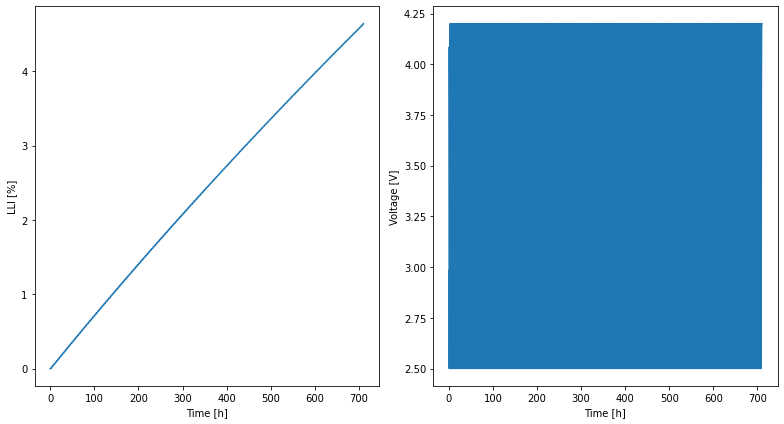

In [15]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

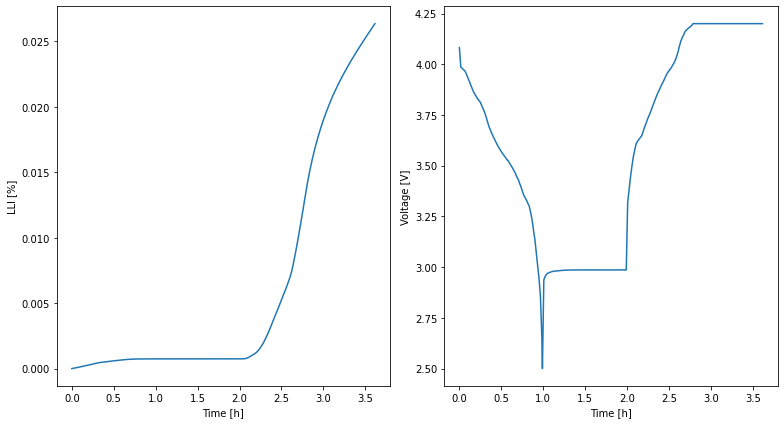

In [16]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [17]:
lli_100 = spm_sol_800["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

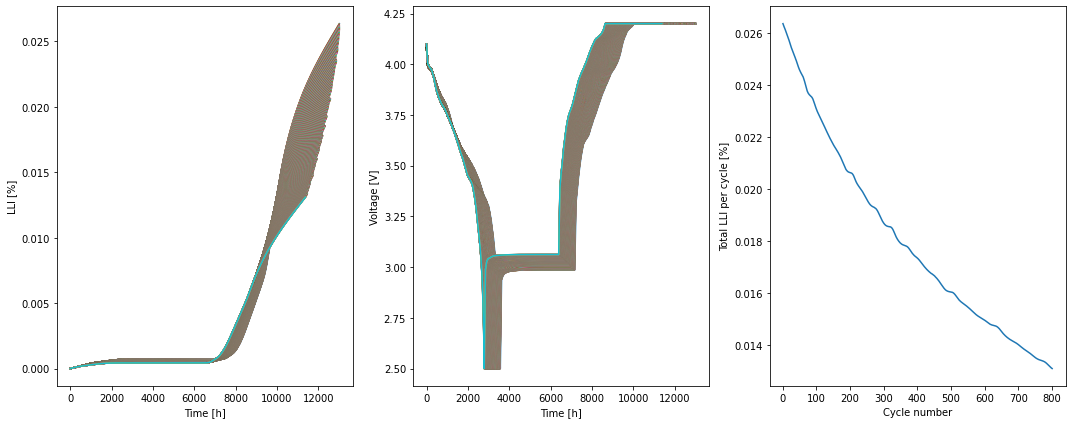

In [18]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_800.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [19]:
len(spm_sol_100.summary_variables.items())

71

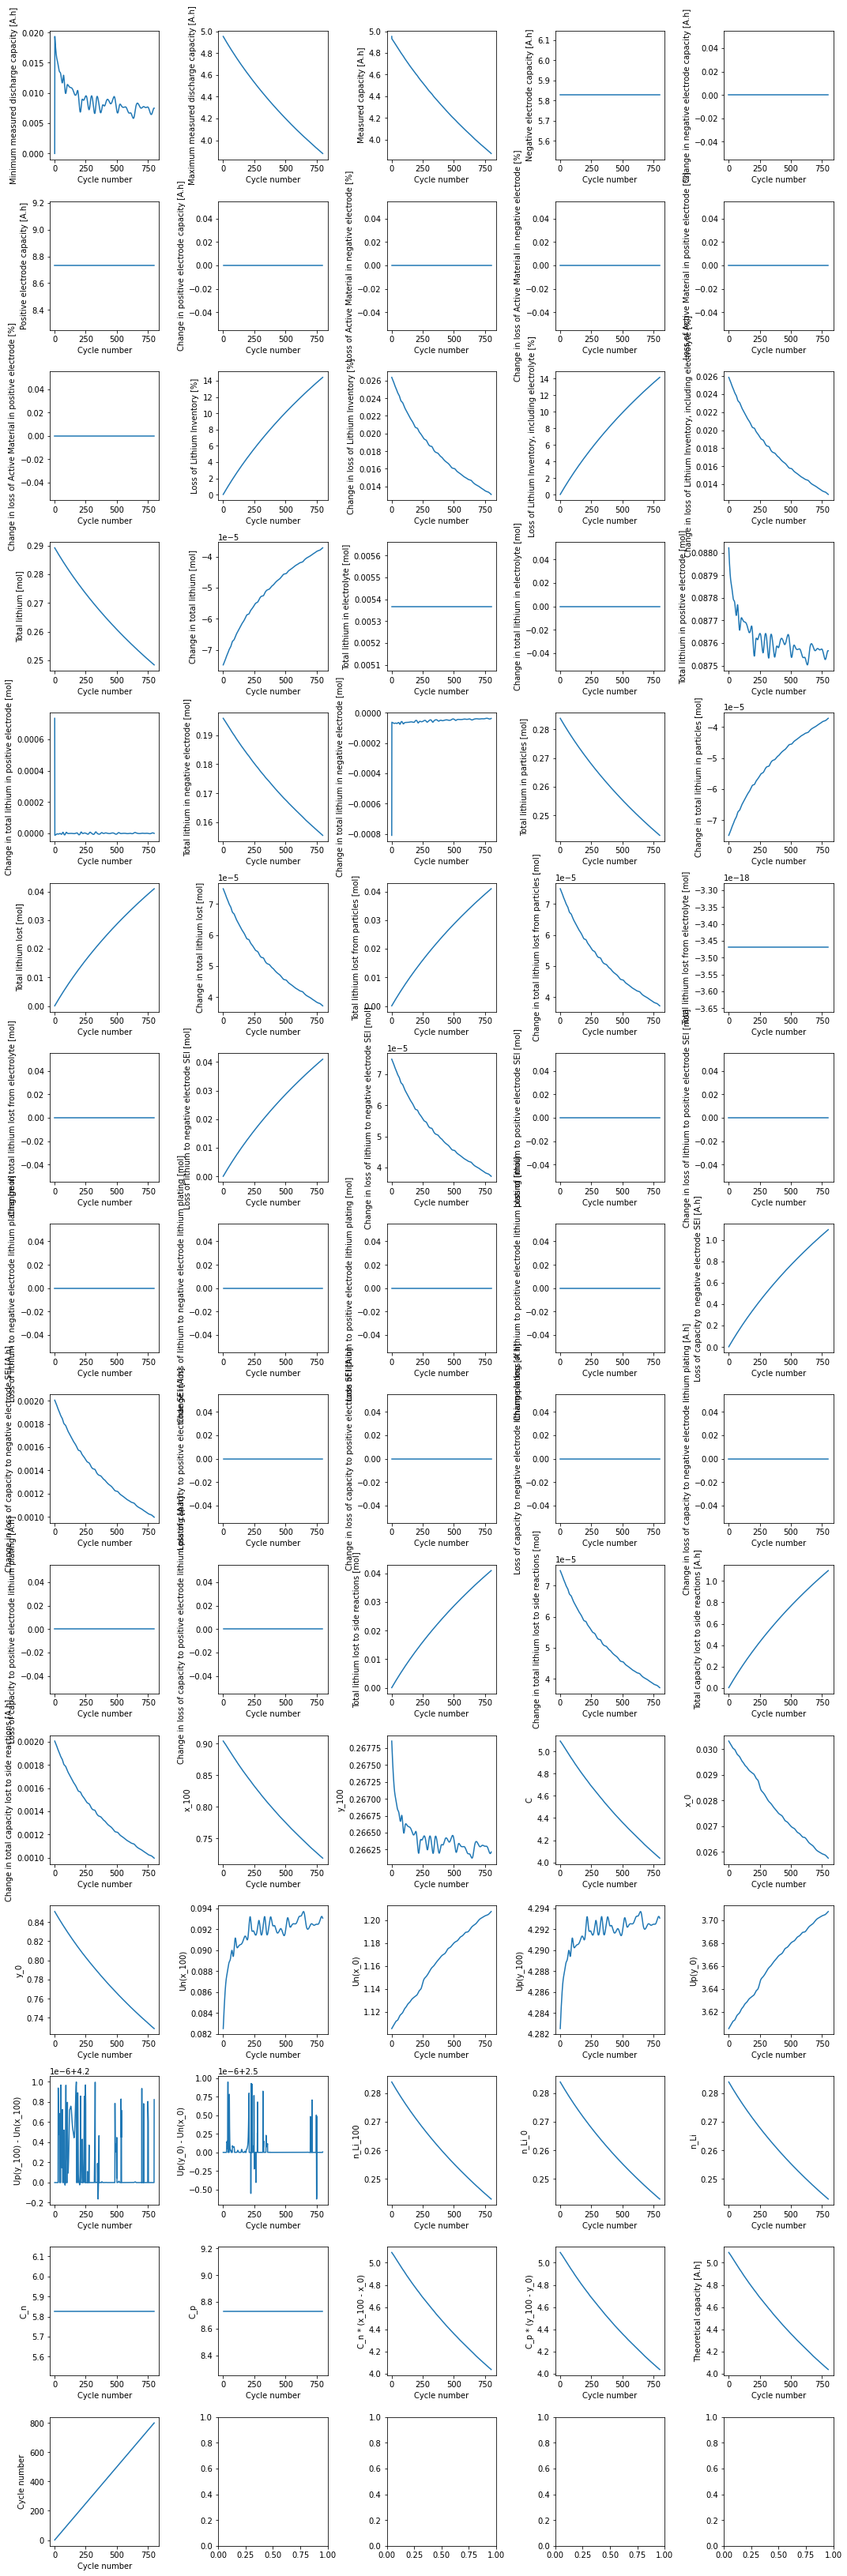

In [48]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_800.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_800.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [21]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-03-03 10:38:56,839 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.500 ms elapsed) --------------------
2021-03-03 10:38:56,839 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 10:38:57,065 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 10:38:57,270 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 10:38:57,467 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 10:38:57,924 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.112 s


Check how well extrapolating 1 cycle does

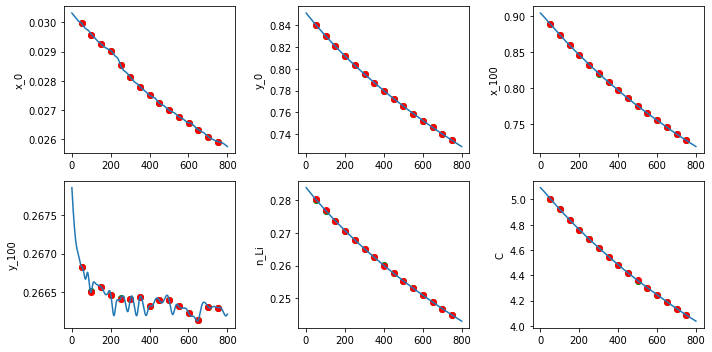

In [22]:
n_cycles_step = 50
long_sol = spm_sol_800
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(long_sol.summary_variables["Cycle number"], long_sol.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(long_sol.cycles)-n_cycles_step:
    n_Li_cycle = long_sol.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,long_sol.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [46]:
n_cycles_step = 60
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[-1] - n_Li_cycle[0]
    
    n_Li = n_Li_cycle_init + delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc.solution.first_state[var.name].data
            last = sim_acc.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step

0


2021-03-03 12:44:20,908 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.437 ms elapsed) --------------------
2021-03-03 12:44:20,909 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:21,111 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:21,297 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:21,465 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:21,920 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.038 s
2021-03-03 12:44:21,968 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.183 ms elapsed) --------------------
2021-03-03 12:44:21,969 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


60


2021-03-03 12:44:22,186 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:22,353 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:22,504 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:22,868 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 928.869 ms
2021-03-03 12:44:22,908 - [NOTICE] simulation.solve(693): Cycle 1/1 (25.437 ms elapsed) --------------------
2021-03-03 12:44:22,909 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


120


2021-03-03 12:44:23,124 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:23,306 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:23,456 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:23,818 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 935.025 ms
2021-03-03 12:44:23,860 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.844 ms elapsed) --------------------
2021-03-03 12:44:23,861 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


180


2021-03-03 12:44:24,071 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:24,248 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:24,392 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:24,729 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 896.438 ms
2021-03-03 12:44:24,778 - [NOTICE] simulation.solve(693): Cycle 1/1 (30.432 ms elapsed) --------------------
2021-03-03 12:44:24,779 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


240


2021-03-03 12:44:24,988 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:25,167 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:25,323 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:25,653 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 905.352 ms
2021-03-03 12:44:25,688 - [NOTICE] simulation.solve(693): Cycle 1/1 (22.591 ms elapsed) --------------------
2021-03-03 12:44:25,689 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


300


2021-03-03 12:44:25,901 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:26,098 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:26,242 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:26,570 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 904.033 ms
2021-03-03 12:44:26,613 - [NOTICE] simulation.solve(693): Cycle 1/1 (28.935 ms elapsed) --------------------
2021-03-03 12:44:26,614 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


360


2021-03-03 12:44:26,819 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:27,004 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:27,152 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:27,506 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 921.654 ms
2021-03-03 12:44:27,551 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.500 ms elapsed) --------------------
2021-03-03 12:44:27,552 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


420


2021-03-03 12:44:27,760 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:27,947 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:28,118 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:28,479 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 957.073 ms
2021-03-03 12:44:28,513 - [NOTICE] simulation.solve(693): Cycle 1/1 (22.685 ms elapsed) --------------------
2021-03-03 12:44:28,514 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:28,707 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:28,868 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V


480


2021-03-03 12:44:29,005 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:29,331 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 839.788 ms
2021-03-03 12:44:29,375 - [NOTICE] simulation.solve(693): Cycle 1/1 (30.547 ms elapsed) --------------------
2021-03-03 12:44:29,376 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:29,560 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


540


2021-03-03 12:44:29,726 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:29,876 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:30,200 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 855.338 ms
2021-03-03 12:44:30,234 - [NOTICE] simulation.solve(693): Cycle 1/1 (23.162 ms elapsed) --------------------
2021-03-03 12:44:30,235 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:30,417 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


600


2021-03-03 12:44:30,579 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:30,722 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:31,103 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 892.055 ms
2021-03-03 12:44:31,146 - [NOTICE] simulation.solve(693): Cycle 1/1 (28.255 ms elapsed) --------------------
2021-03-03 12:44:31,147 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:31,348 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


660


2021-03-03 12:44:31,520 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:31,668 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:32,001 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 883.337 ms
2021-03-03 12:44:32,041 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.915 ms elapsed) --------------------
2021-03-03 12:44:32,041 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:32,225 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


720


2021-03-03 12:44:32,403 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:44:32,540 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:32,850 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 836.505 ms
2021-03-03 12:44:32,890 - [NOTICE] simulation.solve(693): Cycle 1/1 (26.997 ms elapsed) --------------------
2021-03-03 12:44:32,891 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:44:33,048 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:44:33,206 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V


780


2021-03-03 12:44:33,331 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:44:33,676 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 813.519 ms


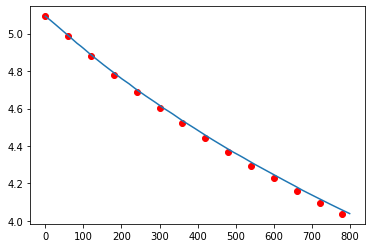

In [47]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(long_sol.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])

2021-03-03 12:39:16,029 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-03-03 12:39:16,030 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


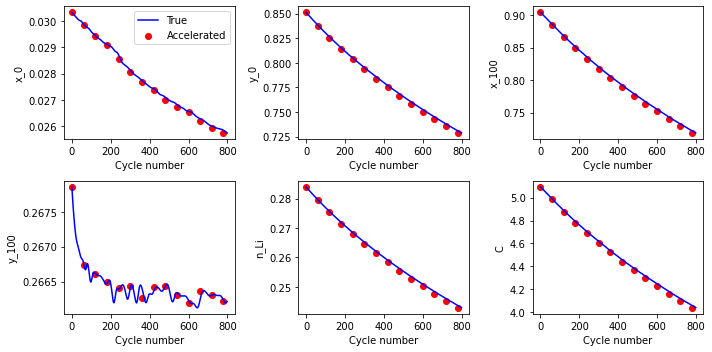

In [45]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_acc],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims.eps", dpi=1000)

### Time upscaling

In [41]:
n_cycles_step = 3
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_upscale = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_upscale = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_upscale.solve()
    
    for var in sol.all_models[0].initial_conditions:
        first = sim_upscale.solution.first_state[var.name].data
        last = sim_upscale.solution.last_state[var.name].data
        ics[var.name] = first + (last - first) * n_cycles_step
    sim_upscale.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)
    print(ics['X-averaged positive particle concentration'])
    cycle_nums.append(cycle)
    sol_upscale.append(sol)
    cycle += n_cycles_step

0


2021-03-03 12:27:35,827 - [NOTICE] simulation.solve(693): Cycle 1/1 (21.810 ms elapsed) --------------------
2021-03-03 12:27:35,827 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:27:36,057 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:27:36,241 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:27:36,427 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:27:36,925 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.120 s
2021-03-03 12:27:36,960 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.747 ms elapsed) --------------------
2021-03-03 12:27:36,961 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.28810488]
 [0.28805397]
 [0.28792696]
 [0.28773028]
 [0.28746648]
 [0.28713763]
 [0.28674592]
 [0.28629375]
 [0.2857838 ]
 [0.28521906]
 [0.28460278]
 [0.28393851]
 [0.28323003]
 [0.28248137]
 [0.28169676]
 [0.28088064]
 [0.28003757]
 [0.27917227]
 [0.27828955]
 [0.27739429]
 [0.27649141]
 [0.27558583]
 [0.27468246]
 [0.27378615]
 [0.27290165]
 [0.27203362]
 [0.27118653]
 [0.27036472]
 [0.26957229]
 [0.2688131 ]]
3


2021-03-03 12:27:37,166 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:27:37,344 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:27:37,498 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:27:37,880 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 949.846 ms
2021-03-03 12:27:37,910 - [NOTICE] simulation.solve(693): Cycle 1/1 (25.321 ms elapsed) --------------------
2021-03-03 12:27:37,910 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.24721928]
 [0.24727084]
 [0.24739948]
 [0.2475987 ]
 [0.24786588]
 [0.24819892]
 [0.24859559]
 [0.24905344]
 [0.24956973]
 [0.25014142]
 [0.25076517]
 [0.25143739]
 [0.25215418]
 [0.25291145]
 [0.25370487]
 [0.25452992]
 [0.25538194]
 [0.2562561 ]
 [0.25714751]
 [0.25805118]
 [0.2589621 ]
 [0.25987525]
 [0.26078563]
 [0.26168831]
 [0.26257844]
 [0.2634513 ]
 [0.26430234]
 [0.26512718]
 [0.26592166]
 [0.26668188]]
6


2021-03-03 12:27:38,124 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:27:38,304 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:27:38,472 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:27:38,831 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 947.051 ms
2021-03-03 12:27:38,862 - [NOTICE] simulation.solve(693): Cycle 1/1 (27.052 ms elapsed) --------------------
2021-03-03 12:27:38,863 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-03 12:27:39,048 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour


[[0.32855087]
 [0.32839812]
 [0.32801706]
 [0.32742693]
 [0.3266354 ]
 [0.32564873]
 [0.32447344]
 [0.32311676]
 [0.32158675]
 [0.31989234]
 [0.31804333]
 [0.31605034]
 [0.31392474]
 [0.31167861]
 [0.30932468]
 [0.30687621]
 [0.30434693]
 [0.301751  ]
 [0.29910282]
 [0.29641705]
 [0.29370844]
 [0.29099177]
 [0.28828174]
 [0.2855929 ]
 [0.28293951]
 [0.28033551]
 [0.27779437]
 [0.27532902]
 [0.27295178]
 [0.27067427]]
9


2021-03-03 12:27:39,217 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:27:39,374 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-03 12:27:39,721 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 885.844 ms
2021-03-03 12:27:39,754 - [NOTICE] simulation.solve(693): Cycle 1/1 (29.613 ms elapsed) --------------------
2021-03-03 12:27:39,755 - [NOTICE] simulation.solve(723): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


[[0.16549781]
 [0.16575427]
 [0.16639405]
 [0.16738483]
 [0.16871371]
 [0.17037015]
 [0.17234317]
 [0.1746206 ]
 [0.17718884]
 [0.18003285]
 [0.1831361 ]
 [0.18648071]
 [0.19004749]
 [0.19381605]
 [0.19776498]
 [0.20187188]
 [0.20611358]
 [0.21046625]
 [0.21490554]
 [0.21940677]
 [0.22394504]
 [0.22849545]
 [0.23303318]
 [0.23753375]
 [0.24197309]
 [0.24632775]
 [0.25057505]
 [0.25469323]
 [0.2586616 ]
 [0.26246065]]
12


2021-03-03 12:27:39,976 - [NOTICE] simulation.solve(723): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-03 12:27:40,159 - [NOTICE] simulation.solve(723): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-03 12:27:40,307 - [NOTICE] simulation.solve(723): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


SolverError: CasADI solver failed because the following interpolation bounds were exceeded at the initial conditions: ['nmc_LGM50_ocp_Chen2020 lower bound']. You may need to provide additional interpolation points outside these bounds.

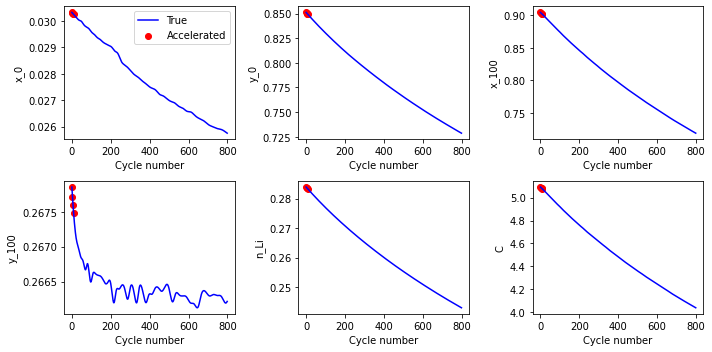

In [42]:
sol_fast = sol_upscale
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()

It doesn't work because y_100 is much too non-linear, so extrapolating the change gives inaccurate results

### Linear extrapolation

In [64]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
] * 2)

sim_acc_linear = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc_linear = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate two cycles
    sol = sim_acc_linear.solve()
    
    n_Li_cycle_init = sol.cycles[-2].first_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_mid = sol.cycles[-2].last_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_last = sol.cycles[-1].last_state["Total lithium in particles [mol]"].data[0]

    delta_nLi_cycle_0 = n_Li_cycle_mid - n_Li_cycle_init
    delta_nLi_cycle_1 = n_Li_cycle_last - n_Li_cycle_mid
    delta_nLi_cycle_N = delta_nLi_cycle_0 + (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step
    
    # Linear extrapolation and integrate (triangle) to get the total n_li over cycles being stepped
#     delta_nLi_total = delta_nLi_cycle_0 + (n_cycles_step-1) * (delta_nLi_cycle_0 + delta_nLi_cycle_N) / 2
    delta_nLi_total = (
        delta_nLi_cycle_0 * n_cycles_step 
        + 1/2 * (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step * (n_cycles_step + 1)
    )
    n_Li = n_Li_cycle_init + delta_nLi_total

    print(n_Li_cycle_init)
    print(n_Li)
    print(n_Li_cycle_init + n_cycles_step * delta_nLi_cycle_0)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc_linear.solution.first_state[var.name].data
            last = sim_acc_linear.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc_linear.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc_linear.append(sol)
    cycle += n_cycles_step

0


2021-03-03 15:49:12,529 - [NOTICE] simulation.solve(693): Cycle 1/2 (22.723 ms elapsed) --------------------
2021-03-03 15:49:12,530 - [NOTICE] simulation.solve(723): Cycle 1/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:12,774 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:12,985 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:13,176 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:13,614 - [NOTICE] simulation.solve(693): Cycle 2/2 (1.108 s elapsed) --------------------
2021-03-03 15:49:13,615 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:13,806 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:13,974 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:14,145 - [NOTICE] simulation.solve(723): Cycle 2/2, step

0.27968615845963096
0.28396609689240004
0.2794745134395431
60


2021-03-03 15:49:14,656 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:14,830 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:14,972 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:15,296 - [NOTICE] simulation.solve(693): Cycle 2/2 (878.629 ms elapsed) --------------------
2021-03-03 15:49:15,297 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:15,471 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:15,651 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:15,805 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:16,095 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.677 s
2021-03-03 15:49:16,122 - [NOTICE] simulation.solve(693): Cycle 1/2 (22.228 ms el

0.27585167060499727
0.27968615845963096
0.27567271453423514
120


2021-03-03 15:49:16,326 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:16,532 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:16,677 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:17,012 - [NOTICE] simulation.solve(693): Cycle 2/2 (911.629 ms elapsed) --------------------
2021-03-03 15:49:17,012 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:17,189 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:17,353 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:17,504 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:17,773 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.673 s
2021-03-03 15:49:17,805 - [NOTICE] simulation.solve(693): Cycle 1/2 (26.800 ms el

0.2723785550724166
0.27585167060499727
0.2722144494299249
180


2021-03-03 15:49:18,009 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:18,213 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:18,366 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:18,718 - [NOTICE] simulation.solve(693): Cycle 2/2 (939.406 ms elapsed) --------------------
2021-03-03 15:49:18,718 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:18,904 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:19,078 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:19,229 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:19,493 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.715 s
2021-03-03 15:49:19,522 - [NOTICE] simulation.solve(693): Cycle 1/2 (23.032 ms el

0.2691553212263852
0.2723785550724166
0.26902918234624085
240


2021-03-03 15:49:20,025 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:20,353 - [NOTICE] simulation.solve(693): Cycle 2/2 (853.484 ms elapsed) --------------------
2021-03-03 15:49:20,353 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:20,524 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:20,671 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:20,815 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:21,063 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.564 s
2021-03-03 15:49:21,090 - [NOTICE] simulation.solve(693): Cycle 1/2 (21.547 ms elapsed) --------------------
2021-03-03 15:49:21,091 - [NOTICE] simulation.solve(723): Cycle 1/2, step 1/4: Discharge at 1C until 2.5V


0.26611820680729414
0.2691553212263852
0.26602547046529856
300


2021-03-03 15:49:21,290 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:21,466 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:21,594 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:21,943 - [NOTICE] simulation.solve(693): Cycle 2/2 (874.291 ms elapsed) --------------------
2021-03-03 15:49:21,943 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:22,133 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:22,294 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:22,435 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:22,694 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.625 s
2021-03-03 15:49:22,722 - [NOTICE] simulation.solve(693): Cycle 1/2 (23.168 ms el

0.26329055752130504
0.26611820680729414
0.26317132045487457
360


2021-03-03 15:49:22,939 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:23,121 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:23,292 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:23,637 - [NOTICE] simulation.solve(693): Cycle 2/2 (938.017 ms elapsed) --------------------
2021-03-03 15:49:23,638 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:23,806 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:23,975 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:24,122 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:24,397 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.697 s
2021-03-03 15:49:24,429 - [NOTICE] simulation.solve(693): Cycle 1/2 (26.690 ms el

0.260651761691849
0.26329055752130504
0.26051943160091395
420


2021-03-03 15:49:24,807 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:24,957 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:25,333 - [NOTICE] simulation.solve(693): Cycle 2/2 (931.100 ms elapsed) --------------------
2021-03-03 15:49:25,334 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:25,498 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:25,653 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:25,786 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:26,030 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.628 s
2021-03-03 15:49:26,058 - [NOTICE] simulation.solve(693): Cycle 1/2 (22.278 ms elapsed) --------------------
2021-03-03 15:49:26,059 - [NOTICE] simulation.solve(723): Cycle 1/2

0.25808168357820893
0.260651761691849
0.25800785583234387
480


2021-03-03 15:49:26,401 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:26,533 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:26,845 - [NOTICE] simulation.solve(693): Cycle 2/2 (808.381 ms elapsed) --------------------
2021-03-03 15:49:26,845 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:27,004 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:27,154 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:27,294 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:27,542 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.506 s
2021-03-03 15:49:27,578 - [NOTICE] simulation.solve(693): Cycle 1/2 (29.349 ms elapsed) --------------------
2021-03-03 15:49:27,579 - [NOTICE] simulation.solve(723): Cycle 1/2

0.25563768505470197
0.25808168357820893
0.25556366115097195
540


2021-03-03 15:49:27,944 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:28,090 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:28,421 - [NOTICE] simulation.solve(693): Cycle 2/2 (872.282 ms elapsed) --------------------
2021-03-03 15:49:28,422 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:28,580 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:28,738 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:28,882 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:29,138 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.589 s
2021-03-03 15:49:29,166 - [NOTICE] simulation.solve(693): Cycle 1/2 (23.402 ms elapsed) --------------------
2021-03-03 15:49:29,167 - [NOTICE] simulation.solve(723): Cycle 1/2

0.2532692438412786
0.25563768505470197
0.2532378563580644
600


2021-03-03 15:49:29,526 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:29,664 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:30,000 - [NOTICE] simulation.solve(693): Cycle 2/2 (857.079 ms elapsed) --------------------
2021-03-03 15:49:30,001 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:30,156 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:30,342 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:30,481 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:30,752 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.609 s
2021-03-03 15:49:30,787 - [NOTICE] simulation.solve(693): Cycle 1/2 (28.993 ms elapsed) --------------------
2021-03-03 15:49:30,788 - [NOTICE] simulation.solve(723): Cycle 1/2

0.2510346403467144
0.2532692438412786
0.25096635175898985
660


2021-03-03 15:49:31,154 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:31,297 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:31,618 - [NOTICE] simulation.solve(693): Cycle 2/2 (860.087 ms elapsed) --------------------
2021-03-03 15:49:31,619 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:31,785 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:31,959 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:32,086 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:32,366 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.607 s
2021-03-03 15:49:32,401 - [NOTICE] simulation.solve(693): Cycle 1/2 (29.286 ms elapsed) --------------------
2021-03-03 15:49:32,402 - [NOTICE] simulation.solve(723): Cycle 1/2

0.248879502869923
0.2510346403467144
0.24882029401511063
720


2021-03-03 15:49:32,604 - [NOTICE] simulation.solve(723): Cycle 1/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:32,811 - [NOTICE] simulation.solve(723): Cycle 1/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:32,958 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:33,296 - [NOTICE] simulation.solve(693): Cycle 2/2 (924.675 ms elapsed) --------------------
2021-03-03 15:49:33,297 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:33,461 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:33,619 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:33,758 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:34,045 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.673 s
2021-03-03 15:49:34,074 - [NOTICE] simulation.solve(693): Cycle 1/2 (24.235 ms el

0.24683576532710905
0.248879502869923
0.24674154123259728
780


2021-03-03 15:49:34,583 - [NOTICE] simulation.solve(723): Cycle 1/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:34,925 - [NOTICE] simulation.solve(693): Cycle 2/2 (875.299 ms elapsed) --------------------
2021-03-03 15:49:34,926 - [NOTICE] simulation.solve(723): Cycle 2/2, step 1/4: Discharge at 1C until 2.5V
2021-03-03 15:49:35,119 - [NOTICE] simulation.solve(723): Cycle 2/2, step 2/4: Rest for 1 hour
2021-03-03 15:49:35,290 - [NOTICE] simulation.solve(723): Cycle 2/2, step 3/4: Charge at 1C until 4.2V
2021-03-03 15:49:35,422 - [NOTICE] simulation.solve(723): Cycle 2/2, step 4/4: Hold at 4.2V until C/50
2021-03-03 15:49:35,682 - [NOTICE] simulation.solve(784): Finish experiment simulation, took 1.632 s


0.24484555584767353
0.24683576532710905
0.24477952680017723


In [67]:
len(cycle_nums)

14

2021-03-08 12:59:10,218 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-03-08 12:59:10,223 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


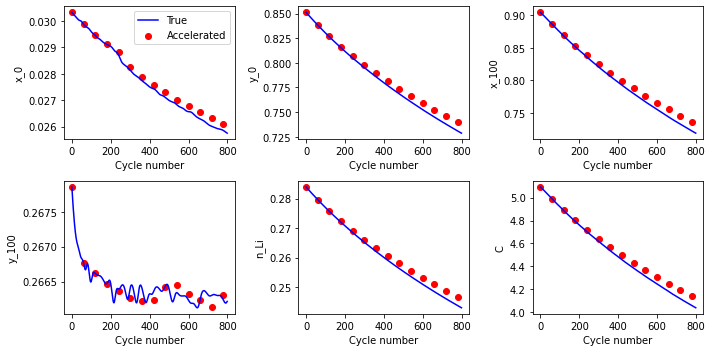

In [68]:
sol_fast = sol_acc_linear
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name][0] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims_linear.eps", dpi=1000)